In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Image

# as 5 decimal places are there in latitude and longitude
pd.options.display.float_format = "{:0.5f}".format

## Calculating distance from coordinates
- ideally we would use Google Maps API to calculate "road" distance. This is a *paid* API.
  - https://developers.google.com/maps/documentation/directions/overview
- For our estimate we will use haversine distance
  - `Haversine distance`: underestimate of the true travel distance by road. 
  - It is also called `great circle distance` (the shortest distance over the earth’s surface)
  - We can imagine it as ‘as-the-crow-flies’ distance between the points, ignoring any hills they fly over
  - https://en.wikipedia.org/wiki/Haversine_formula
- There are other more accurate estimatations such as `Vincenty's formulae` or `Keerthana`
  - although they don't assume Earth to be a perfect sphere, all of them are underestimates of road distance
  - https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

In [31]:
# https://en.wikipedia.org/wiki/Haversine_formula
# vectorized haversine function to calculate great circle distance
def haversine(lat1, lng1, lat2, lng2, avg_earth_radius=6371):
    """
    modified from here: http://stackoverflow.com/a/29546836/2901002

    returns great circle distance (in miles) between two points
    on the earth
    """

    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])

    a = (
        np.sin((lat2 - lat1) / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin((lng2 - lng1) / 2.0) ** 2
    )

    return avg_earth_radius * 2 * np.arcsin(np.sqrt(a)) * 0.621371  # in miles

In [41]:
def read_cabs_data(data_folder):
    """reads all txt files from a folder,
    changes column names and dtypes,
    and concats them into a one big dataframe"""
    file_generator = Path(data_folder).glob("*.txt")
    cabs_data = []
    for file in file_generator:
        df = pd.read_csv(file, header=None, delimiter=" ")
        df["cab_id"] = file.stem
        df.columns = ["lat", "lng", "occupancy", "datetime", "cab_id"]
        df["datetime"] = pd.to_datetime(df["datetime"], unit="s")
        df["occupancy"] = df.occupancy.astype("category")
        df["cab_id"] = df.cab_id.astype("category")

        # haversine dist
        df = df.assign(
            haver_dist_miles=haversine(
                df.lat.shift(), df.lng.shift(), df.loc[1:, "lat"], df.loc[1:, "lng"]
            )
        )
        cabs_data.append(df)

    # concatenate all data into one df
    cabs_df = pd.concat(cabs_data, ignore_index=True)
    print(f"data shape: {cabs_df.shape}")
    return cabs_df


cabs_df = read_cabs_data("../data/raw_data/cabspottingdata")
cabs_df.sample(5)

data shape: (11220058, 6)


,lat,lng,occupancy,datetime,cab_id,haver_dist_miles
10552594,37.78631,-122.41474,1,2008-05-30 21:30:02,new_ijtowhur,0.18559
6345974,37.79492,-122.42491,1,2008-05-25 04:13:53,new_imwyojy,0.34666
9762224,37.73554,-122.40462,1,2008-05-30 01:16:12,new_agjitfa,0.89311
3274449,37.61752,-122.38488,0,2008-06-06 05:41:34,new_okchympy,0.21490
6829441,37.78447,-122.38790,1,2008-05-23 20:57:35,new_eedigkr,0.18969


In [33]:
# fill missing values of dist with 0
cabs_df.haver_dist_miles = cabs_df.haver_dist_miles.fillna(0)

In [34]:
cabs_df.haver_dist_miles.describe()

count   11220058.00000
mean           0.25607
std            1.40550
min            0.00000
25%            0.02015
50%            0.14518
75%            0.28595
max          877.11334
Name: haver_dist_miles, dtype: float64

##  Data is too granular - Aggregating on trip level (trip distance and trip duration)

A `trip` can be defined in this dataset for a cab as duration until the occupancy value changes
from 0 to 1 or 1 to 0.

- `Observation/Fact`: calculating haversine distances first on small durations, and then aggregating is better to 
avoid `GPS errors`


In [87]:
# aggregate data on trip level and find duration of trips
trip_status_change = (cabs_df.occupancy != cabs_df.occupancy.shift()).cumsum()
trip_df = cabs_df.groupby(["cab_id", trip_status_change], as_index=False, sort=False)[
    "occupancy", "haver_dist_miles", "lat", "lng", "datetime"
].agg(
    {
        "occupancy": "first",
        "haver_dist_miles": "sum",
        "lat": ["first", "last"],
        "lng": ["first", "last"],
        "datetime": ["first", "last"],
    }
)
trip_df.columns = trip_df.columns.droplevel(1)
trip_df.columns = [
    "cab_id",
    "occupancy",
    "haver_dist_miles",
    "trip_start_lat",
    "trip_end_lat",
    "trip_start_lng",
    "trip_end_lng",
    "trip_start_time",
    "trip_end_time",
]
trip_df = trip_df.assign(
    trip_duration=(trip_df.trip_end_time - trip_df.trip_start_time)
)
# trip_df = trip_df[['cab_id', 'occupancy', 'trip_duration', 'haver_dist_miles']]
trip_df.head()

/Users/smiglani002/Desktop/personal_projects/cabspotting_pmi/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,cab_id,occupancy,haver_dist_miles,trip_start_lat,trip_end_lat,trip_start_lng,trip_end_lng,trip_start_time,trip_end_time,trip_duration
0,new_adkavy,0,11.51415,37.79826,37.78705,-122.26613,-122.41098,2008-05-17 14:25:37,2008-05-17 15:52:58,0 days 01:27:21
1,new_adkavy,1,13.40805,37.78726,37.61468,-122.41110,-122.38974,2008-05-17 15:53:13,2008-05-17 16:12:02,0 days 00:18:49
2,new_adkavy,0,0.81418,37.61467,37.61656,-122.38975,-122.38590,2008-05-17 16:12:19,2008-05-17 16:59:08,0 days 00:46:49
3,new_adkavy,1,13.51842,37.61464,37.78578,-122.39350,-122.42814,2008-05-17 17:44:27,2008-05-17 18:05:40,0 days 00:21:13
4,new_adkavy,0,1.32891,37.78583,37.78632,-122.42816,-122.43902,2008-05-17 18:05:42,2008-05-17 18:13:24,0 days 00:07:42


In [88]:
trip_df[["haver_dist_miles", "trip_duration"]].describe()

,haver_dist_miles,trip_duration
count,928307.00000,928307
mean,3.09501,0 days 00:16:55.129745870
std,9.22234,0 days 01:40:39.339880159
min,0.00000,0 days 00:00:00
25%,0.57204,0 days 00:03:36
50%,1.38442,0 days 00:07:36
75%,2.81065,0 days 00:13:55
max,1787.31719,19 days 08:07:10


<AxesSubplot:xlabel='haver_dist_miles', ylabel='trip_duration_hrs'>

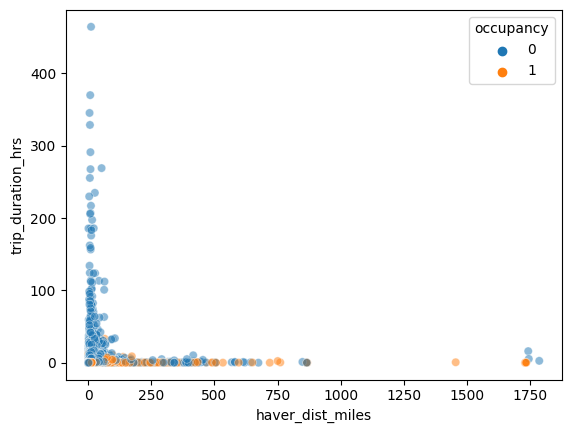

In [89]:
# Plot doesn't look right! -- contains OUTLIERS !!
trip_df["trip_duration_hrs"] = trip_df["trip_duration"].dt.total_seconds() / 3600.0
sns.scatterplot(
    data=trip_df,
    x="haver_dist_miles",
    y="trip_duration_hrs",
    hue="occupancy",
    alpha=0.5,
)

In [90]:
trip_df.sort_values("haver_dist_miles", ascending=False)
# We see large distances travelled in a few hours

,cab_id,occupancy,haver_dist_miles,trip_start_lat,trip_end_lat,trip_start_lng,trip_end_lng,trip_start_time,trip_end_time,trip_duration,trip_duration_hrs
557046,new_ecforj,0,1787.31719,37.64074,37.75372,-122.40597,-122.43360,2008-05-21 12:54:15,2008-05-21 15:35:13,0 days 02:40:58,2.68278
668096,new_acvebr,0,1745.86537,37.75983,37.75664,-122.42538,-122.41881,2008-05-24 01:55:45,2008-05-24 07:20:55,0 days 05:25:10,5.41944
306464,new_atzumbon,0,1743.65588,37.77199,37.75181,-122.45406,-122.39434,2008-05-19 20:45:02,2008-05-20 12:48:08,0 days 16:03:06,16.05167
898376,new_ojpoota,1,1735.74258,37.78335,37.74418,-122.42514,-122.43212,2008-06-04 21:58:24,2008-06-04 22:12:18,0 days 00:13:54,0.23167
562733,new_oogchyog,1,1734.82054,37.79854,37.76251,-122.41221,-122.42174,2008-05-20 15:41:06,2008-05-20 15:55:17,0 days 00:14:11,0.23639
...,...,...,...,...,...,...,...,...,...,...,...
374998,new_ebrulra,0,0.00000,37.76507,37.76507,-122.48455,-122.48455,2008-05-19 02:20:37,2008-05-19 02:20:37,0 days 00:00:00,0.00000
267247,new_amwibs,0,0.00000,37.76711,37.76711,-122.42901,-122.42901,2008-06-06 03:42:54,2008-06-06 03:42:54,0 days 00:00:00,0.00000
659978,new_osoccef,0,0.00000,37.79461,37.79461,-122.41304,-122.41304,2008-06-08 17:47:34,2008-06-08 17:47:34,0 days 00:00:00,0.00000
375012,new_ebrulra,0,0.00000,37.76980,37.76980,-122.42469,-122.42469,2008-05-19 04:38:09,2008-05-19 04:38:09,0 days 00:00:00,0.00000


In [91]:
# we see very large trip durations for small distances
# maybe this includes offline durations (Where cab driver is resting at one place)
# for this we can remove rows with zero distance before aggregating
trip_df.sort_values("trip_duration", ascending=False)

,cab_id,occupancy,haver_dist_miles,trip_start_lat,trip_end_lat,trip_start_lng,trip_end_lng,trip_start_time,trip_end_time,trip_duration,trip_duration_hrs
114640,new_ayshowg,0,10.70623,37.75134,37.78574,-122.39375,-122.40288,2008-05-19 09:11:51,2008-06-07 17:19:01,19 days 08:07:10,464.11944
58988,new_imhacy,0,7.44459,37.77337,37.76681,-122.42227,-122.38901,2008-05-22 15:23:54,2008-06-07 01:06:43,15 days 09:42:49,369.71361
830882,new_idjoat,0,4.81120,37.75171,37.75518,-122.39520,-122.42090,2008-05-23 14:33:27,2008-06-06 23:39:06,14 days 09:05:39,345.09417
678764,new_elvgid,0,6.40535,37.77672,37.75171,-122.39754,-122.39391,2008-05-22 06:01:33,2008-06-04 22:34:53,13 days 16:33:20,328.55556
769146,new_isnthli,0,8.20983,37.72012,37.73815,-122.47614,-122.40366,2008-05-25 08:14:16,2008-06-06 11:09:00,12 days 02:54:44,290.91222
...,...,...,...,...,...,...,...,...,...,...,...
431951,new_erwumu,0,0.00088,37.76147,37.76147,-122.40810,-122.40810,2008-06-02 17:10:03,2008-06-02 17:10:03,0 days 00:00:00,0.00000
297802,new_aysmsla,0,0.00129,37.76972,37.76972,-122.44890,-122.44890,2008-05-20 23:39:39,2008-05-20 23:39:39,0 days 00:00:00,0.00000
214979,new_acpegho,0,0.01741,37.77591,37.77591,-122.41929,-122.41929,2008-05-18 21:01:24,2008-05-18 21:01:24,0 days 00:00:00,0.00000
59187,new_ichikiga,0,0.04600,37.79379,37.79379,-122.39285,-122.39285,2008-05-18 15:13:36,2008-05-18 15:13:36,0 days 00:00:00,0.00000


## Removing Outliers

#### Calculating estimate of avg. Speed of a cab
- As `speed = distance/time`, It will help us in determining outliers
  - Speeds too large (not possible for a cab) -> distance too large taking small time
  - Speeds close to zero -> distance too small taking long time
  
--- 

#### Taking into account GPS error and offline times of drivers
We see unusually large durations in trips e.g, 19 days. Thus, also removing rows with 0 dist before aggregation 
- Assumption: while removing zero rows, we also remove close to zero rows pertaining to GPS error
- https://en.wikipedia.org/wiki/Error_analysis_for_the_Global_Positioning_System

In [101]:
# aggregate data on trip level and find duration of trips


def agg_trips(cabs_df):
    """aggregates cab data on trip level, and adds a column for trip duration"""

    # remove zero rows
    # https://en.wikipedia.org/wiki/Error_analysis_for_the_Global_Positioning_System
    cabs_df = cabs_df.loc[
        ~(cabs_df.haver_dist_miles < 0.002)
    ]  # typical GPS error is 3 meters or ~0.002 miles

    trip_status_change = (cabs_df.occupancy != cabs_df.occupancy.shift()).cumsum()
    trip_df = cabs_df.groupby(
        ["cab_id", trip_status_change], as_index=False, sort=False
    )["occupancy", "haver_dist_miles", "lat", "lng", "datetime"].agg(
        {
            "occupancy": "first",
            "haver_dist_miles": "sum",
            "lat": ["first", "last"],
            "lng": ["first", "last"],
            "datetime": ["first", "last"],
        }
    )
    trip_df.columns = trip_df.columns.droplevel(1)
    trip_df.columns = [
        "cab_id",
        "occupancy",
        "haver_dist_miles",
        "trip_start_lat",
        "trip_end_lat",
        "trip_start_lng",
        "trip_end_lng",
        "trip_start_time",
        "trip_end_time",
    ]
    trip_df = trip_df.assign(
        trip_duration=(trip_df.trip_end_time - trip_df.trip_start_time)
    )
    # remove rows where trip duration is zero
    trip_df = trip_df.loc[~(trip_df.trip_duration == 0)]

    # calculate speed
    trip_df = trip_df.assign(
        speed_miles_hr=(
            trip_df.haver_dist_miles
            / (trip_df["trip_duration"].dt.total_seconds() / 3600.0)
        )
    )
    return trip_df


trip_df = agg_trips(cabs_df)
trip_df.head()

/Users/smiglani002/Desktop/personal_projects/cabspotting_pmi/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


,cab_id,occupancy,haver_dist_miles,trip_start_lat,trip_end_lat,trip_start_lng,trip_end_lng,trip_start_time,trip_end_time,trip_duration,speed_miles_hr
0,new_adkavy,0,11.50841,37.79826,37.78705,-122.26613,-122.41098,2008-05-17 14:25:37,2008-05-17 15:52:58,0 days 01:27:21,7.90503
1,new_adkavy,1,13.40805,37.78726,37.61468,-122.41110,-122.38974,2008-05-17 15:53:13,2008-05-17 16:12:02,0 days 00:18:49,42.75376
2,new_adkavy,0,0.78039,37.61473,37.61656,-122.39468,-122.38590,2008-05-17 16:13:05,2008-05-17 16:59:08,0 days 00:46:03,1.01680
3,new_adkavy,1,13.51754,37.61464,37.78579,-122.39350,-122.42813,2008-05-17 17:44:27,2008-05-17 18:05:03,0 days 00:20:36,39.37148
4,new_adkavy,0,1.32891,37.78583,37.78632,-122.42816,-122.43902,2008-05-17 18:05:42,2008-05-17 18:13:24,0 days 00:07:42,10.35512


In [104]:
trip_df.speed_miles_hr.describe()

count   866401.00000
mean             inf
std              NaN
min          0.00863
25%          9.33879
50%         12.93069
75%         18.72658
max              inf
Name: speed_miles_hr, dtype: float64

<AxesSubplot:xlabel='speed_miles_hr'>

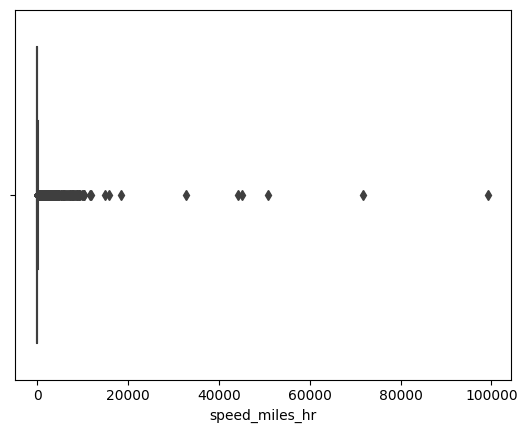

In [108]:
sns.boxplot(x="speed_miles_hr", hue="occupancy", data=trip_df)

<AxesSubplot:xlabel='speed_miles_hr'>

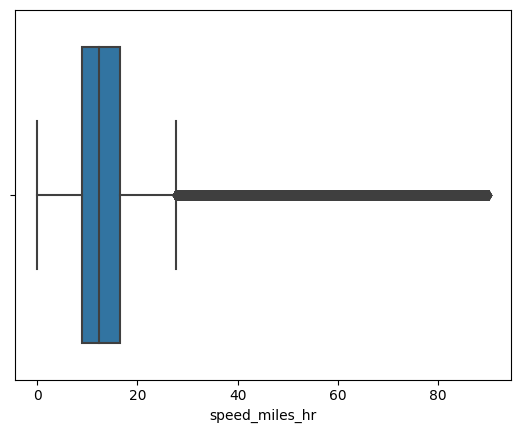

In [110]:
# Removing obvious outliers
# max speed of a car in mph 253.81 mph (Bugatti Veyron EB) -- taxi's should be less than this
# considering speed limits - 70mph. let's consider overspeeding drivers and take up to 90 mph.
# considering lower speed limit -- for car to substantially move --> 0.03 miles ~ 50 meters
trip_df = trip_df.loc[(trip_df.speed_miles_hr <= 90) & (trip_df.speed_miles_hr >= 0.03)]
sns.boxplot(x="speed_miles_hr", hue="occupancy", data=trip_df)